In [ ]:
!sudo apt-get update
!sudo apt-get install stockfish

In [ ]:
!pip install --upgrade pip
!pip install chess zstandard

Edit pgn file to remove unnecessary details

In [ ]:
import re


In [ ]:

def reinstate_move_numbers(moves):
    tokens = moves.strip().split()
    result = []
    for i in range(0, len(tokens), 2):
        move_number = i // 2 + 1
        if i + 1 < len(tokens):
            result.append(f"{move_number}. {tokens[i]} {tokens[i+1]}")
        else:
            result.append(f"{move_number}. {tokens[i]}")
    return " ".join(result)

def clean_and_reformat_pgn(pgn_text):
    games = re.split(r'\n\s*\n', pgn_text.strip())

    cleaned_games = []

    for game in games:
        header_lines = []
        move_lines = []

        for line in game.strip().splitlines():
            if line.startswith('['):
                header_lines.append(line)
            else:
                move_lines.append(line)

        header = "\n".join(header_lines)
        moves_raw = " ".join(move_lines)

        # Remove unnecessary symbols (information)
        moves = re.sub(r"\{[^}]*\}", "", moves_raw)
        
        moves = re.sub(r"\d+\.\.\.", "", moves)
        # Remove all numbers at moves
        moves = re.sub(r"\d+\.", "", moves)
        # Reduziere Leerzeichen
        moves = re.sub(r"\s+", " ", moves).strip()
        # Reformat
        moves_numbered = reinstate_move_numbers(moves)

        cleaned_game = f"{header}\n\n{moves_numbered}"
        cleaned_games.append(cleaned_game)

    return "\n\n".join(cleaned_games)

# Load pgn
with open("/workspaces/Chess_Stockfish/lichess_sample_10000 (1).pgn", "r", encoding="utf-8") as file:
    raw_pgn = file.read()

# Change pgn
cleaned_pgn = clean_and_reformat_pgn(raw_pgn)

# Write in new pgn
with open("/workspaces/Chess_Stockfish/cleaned.pgn", "w", encoding="utf-8") as out_file:
    out_file.write(cleaned_pgn)



Reduce empty lines in pgn

In [ ]:
def reduce_blank_lines_in_pgn(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as infile:
        lines = infile.readlines()

    cleaned_lines = []
    current_game = []
    blank_line_count = 0

    def flush_game(game_lines):
        """Schreibe ein einzelnes Spiel mit genau einer Leerzeile nach dem Header."""
        cleaned = []
        header_ended = False
        blank_line_count = 0
        for line in game_lines:
            stripped = line.strip()
            if stripped.startswith("["):  
                cleaned.append(line)
                header_ended = False
                blank_line_count = 0
            elif stripped == "":
                if not header_ended:
                    if blank_line_count == 0:
                        cleaned.append("\n")
                    blank_line_count += 1
                    header_ended = True
            else:
                cleaned.append(line)
                blank_line_count = 0
        cleaned.append("\n")  # Game end: one empty line
        return cleaned

    for line in lines:
        if line.strip() == "" and not current_game:
            # Emptly line game beginning -> continiue
            continue
        current_game.append(line)
        if line.strip().startswith("[Event") and len(current_game) > 1:
            # New game starts, evaluate last game
            cleaned_lines.extend(flush_game(current_game[:-1]))
            current_game = [line]

    if current_game:
        cleaned_lines.extend(flush_game(current_game))

    with open(output_path, "w", encoding="utf-8") as outfile:
        outfile.writelines(cleaned_lines)
reduce_blank_lines_in_pgn("/workspaces/Chess_Stockfish/cleaned.pgn", "cleaned_one_line.pgn")

Funktion to analyse every game 

In [ ]:
import chess
import chess.pgn

#Elo scales, 1978 FIDE 
def get_elo_bucket(elo):
    if elo < 1000:
        return "beginner" #Novices 
    elif elo < 1400:
        return "intermediate" #Class E and D
    elif elo < 1800:
        return "club_player" #Class C and B
    elif elo < 2200:
        return "advanced" #Class A and Experts
    else:
        return "expert" #Masters
# Game result   
def result_to_label(result, player):
    if result == "1-0":
        return "win" if player == "white" else "loss"
    elif result == "0-1":
        return "win" if player == "black" else "loss"
    elif result == "1/2-1/2":
        return "draw"
    else:
        return "unknown"    

def analyze_game(game, engine, game_nr, depth=19):
    board = game.board()
    data = []

    white_elo = int(game.headers.get("WhiteElo", 0))
    black_elo = int(game.headers.get("BlackElo", 0))
    result = game.headers.get("Result", "*")  # "1-0", "0-1", "1/2-1/2"

    for ply, move in enumerate(game.mainline_moves()):
        san_move = board.san(move)

        # Determine player and elo bucket
        if ply % 2 == 0:
            player = "white"
            elo_level = get_elo_bucket(white_elo)
        else:
            player = "black"
            elo_level = get_elo_bucket(black_elo)

        # Evaluation before move
        info_before = engine.analyse(board, chess.engine.Limit(depth=depth))
        score_before = (
            info_before["score"].white().score(mate_score=10000)
            if not info_before["score"].is_mate()
            else 10000
        )

        # Best move evaluation
        best_move = info_before["pv"][0] if "pv" in info_before else None
        if best_move:
            best_board = board.copy()
            best_board.push(best_move)
            info_best = engine.analyse(best_board, chess.engine.Limit(depth=depth))
            score_best = (
                info_best["score"].white().score(mate_score=10000)
                if not info_best["score"].is_mate()
                else 10000
            )
        else:
            score_best = None

        # Apply actual move and evaluate
        board.push(move)
        info_after = engine.analyse(board, chess.engine.Limit(depth=depth))
        score_after = (
            info_after["score"].white().score(mate_score=10000)
            if not info_after["score"].is_mate()
            else 10000
        )

        # Evaluate move quality
        if best_move == move:
            move_quality = 0
        else:
            move_quality = (
                abs(score_after - score_best) if score_best is not None else None
            )

        # Determine game phase
        total_plies = len(list(game.mainline_moves()))
        if ply < total_plies * 0.3:
            phase = "opening"
        elif ply < total_plies * 0.7:
            phase = "middlegame"
        else:
            phase = "endgame"

        # Record data
        data.append(
            {
                "game_nr": game_nr,
                "ply": ply,
                "move": san_move,
                "move_quality": move_quality,
                "player": player,
                "elo_level": elo_level,
                "phase": phase,
                "result": result_to_label(result, player),
            }
        )

    return data



Evaluation of 1000 games copied in json file 

In [ ]:
import json
import os
import chess
import chess.engine
import chess.pgn

DATA_FILE_2 = "chess_data_all_phases.json"
PGN_FILE = "/workspaces/ChessSeminar/cleaned_one_line.pgn"
ENGINE_PATH = "/usr/games/stockfish"
MAX_GAMES = 1000

def save_data(new_data):
    if os.path.exists(DATA_FILE_2):
        with open(DATA_FILE_2, "r") as f:
            existing_data = json.load(f)
    else:
        existing_data = []
    existing_data.extend(new_data)
    with open(DATA_FILE_2, "w") as f:
        json.dump(existing_data, f, indent=2)

def load_data():
    if os.path.exists(DATA_FILE_2):
        with open(DATA_FILE_2, "r") as f:
            return json.load(f)
    else:
        return []

# === Main ===
engine = chess.engine.SimpleEngine.popen_uci(ENGINE_PATH)
all_data = load_data()

# Determine last analyzed game number
if all_data:
    last_game_nr = max(d["game_nr"] for d in all_data)
else:
    last_game_nr = 0

with open(PGN_FILE) as pgn:
    # Skip previously analyzed games
    for _ in range(last_game_nr):
        if chess.pgn.read_game(pgn) is None:
            break  # End of file reached

    game_count = 0
    while game_count < MAX_GAMES:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break  # No more games

        current_game_nr = last_game_nr + game_count + 1
        print(f"Analyse game {current_game_nr}...")

        try:
            new_game_data = analyze_game(game, engine, game_nr=current_game_nr)

            expected_plies = len(list(game.mainline_moves()))
            if len(new_game_data) == expected_plies:
                save_data(new_game_data)
                print(f"Game {current_game_nr} saved.")
            else:
                print(f"Game {current_game_nr} NOT saved – analyzation not complete.")    

            game_count += 1
        except KeyboardInterrupt:
            print("Analyzation stoped. Game was not saved.")
            break

engine.quit()


Game Opening Function

In [1]:
#Opening

import chess
import chess.pgn

#Elo scales, 1978 FIDE 
def get_elo_bucket(elo):
    if elo < 1000:
        return "beginner" #Novices 
    elif elo < 1400:
        return "intermediate" #Class E and D
    elif elo < 1800:
        return "club_player" #Class C and B
    elif elo < 2200:
        return "advanced" #Class A and Experts
    else:
        return "expert" #Masters

# Convert game result into a label (perspective white)    
def result_to_label(result, player):
    if result == "1-0":
        return "win" if player == "white" else "loss"
    elif result == "0-1":
        return "win" if player == "black" else "loss"
    elif result == "1/2-1/2":
        return "draw"
    else:
        return "unknown"    

# Analyze opening phase of a game with engine comparison
def analyze_opening(game, engine, game_nr, depth=20):
    board = game.board()
    moves = []

    white_elo = int(game.headers.get("WhiteElo", 0))
    black_elo = int(game.headers.get("BlackElo", 0))
    result = game.headers.get("Result", "*")

    total_plies = len(list(game.mainline_moves()))
    opening_limit = int(total_plies * 0.3)
    sequence = []
    engine_sequence = []

    for ply, move in enumerate(game.mainline_moves()):
        if ply >= opening_limit:
            break

        san_move = board.san(move)
        sequence.append(san_move)

        info_before = engine.analyse(board, chess.engine.Limit(depth=depth))
        best_move = info_before["pv"][0] if "pv" in info_before else None

        if best_move:
            best_board = board.copy()
            best_board.push(best_move)
            info_best = engine.analyse(best_board, chess.engine.Limit(depth=depth))
            score_best = (
                info_best["score"].white().score(mate_score=10000)
                if not info_best["score"].is_mate()
                else 10000
            )
            engine_sequence.append(board.san(best_move))
        else:
            score_best = None
            engine_sequence.append(None)

        board.push(move)
        info_after = engine.analyse(board, chess.engine.Limit(depth=depth))
        score_after = (
            info_after["score"].white().score(mate_score=10000)
            if not info_after["score"].is_mate()
            else 10000
        )

        player = "white" if ply % 2 == 0 else "black"
        move_quality = (
            0 if best_move == move else abs(score_after - score_best) if score_best is not None else None
        )

        moves.append({
            "ply": ply,
            "move": san_move,
            "move_quality": move_quality,
            "player": player
        })

    return {
        "game_nr": game_nr,
        "white_elo": white_elo,
        "black_elo": black_elo,
        "elo_level_white": get_elo_bucket(white_elo),
        "elo_level_black": get_elo_bucket(black_elo),
        "result": result,
        "human_opening_sequence": " ".join(sequence),
        "engine_opening_sequence": " ".join(engine_sequence),
        "moves": moves
    }




In [ ]:
import json
import os
import chess
import chess.engine
import chess.pgn
from io import StringIO

DATA_FILE = "chess_data_opening.json"

def save_data(new_data):
    if os.path.exists(DATA_FILE):
        with open(DATA_FILE, "r") as f:
            existing_data = json.load(f)
    else:
        existing_data = []

    existing_data.extend(new_data)

    with open(DATA_FILE, "w") as f:
        json.dump(existing_data, f, indent=2)

def load_data():
    if os.path.exists(DATA_FILE):
        with open(DATA_FILE, "r") as f:
            return json.load(f)
    else:
        return []

PGN_FILE = "/workspaces/ChessSeminar/cleaned_one_line.pgn"
engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

MAX_GAMES = 10000
game_count = 0

all_data = load_data()

# Evaluate last saved game_nr
if all_data:
    last_game_nr = max(d["game_nr"] for d in all_data)
else:
    last_game_nr = 0
#
current_game_nr = last_game_nr
#

with open(PGN_FILE) as pgn:
#
    for _ in range(current_game_nr):
        chess.pgn.read_game(pgn)

#

    while game_count < MAX_GAMES:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break

        game_count += 1
        current_game_nr = last_game_nr + game_count
        print(f"Analyse game {current_game_nr}...")

        try:
            new_game_data = analyze_opening(game, engine, game_nr=current_game_nr)

            # Expected plies in opening phase (like in analyze_opening)
            total_plies = len(list(game.mainline_moves()))
            opening_limit = int(total_plies * 0.3)

            # Check if all opening moves were analyzed (length of moves list inside new_game_data)
            if len(new_game_data["moves"]) == opening_limit:
                save_data([new_game_data])  # Save as a list of one item
                print(f"Game {current_game_nr} saved.")
            else:
                print(f"Game {current_game_nr} NOT saved.")
        except KeyboardInterrupt:
            print("Analysis canceled. Keyboard Interrupt.")
            break

engine.quit()


Analyse game 1108...
Game 1108 saved.
Analyse game 1109...
Game 1109 saved.
Analyse game 1110...
Game 1110 saved.
Analyse game 1111...
Game 1111 saved.
Analyse game 1112...
Game 1112 saved.
Analyse game 1113...
Game 1113 saved.
Analyse game 1114...
Game 1114 saved.
Analyse game 1115...
Game 1115 saved.
Analyse game 1116...
Game 1116 saved.
Analyse game 1117...
Game 1117 saved.
Analyse game 1118...
Game 1118 saved.
Analyse game 1119...
Game 1119 saved.
Analyse game 1120...
Game 1120 saved.
Analyse game 1121...
Game 1121 saved.
Analyse game 1122...
Game 1122 saved.
Analyse game 1123...
Game 1123 saved.
Analyse game 1124...
Game 1124 saved.
Analyse game 1125...
Game 1125 saved.
Analyse game 1126...
Game 1126 saved.
Analyse game 1127...
Game 1127 saved.
Analyse game 1128...
Game 1128 saved.
Analyse game 1129...
Game 1129 saved.
Analyse game 1130...
Game 1130 saved.
Analyse game 1131...
Game 1131 saved.
Analyse game 1132...
Game 1132 saved.
Analyse game 1133...
Game 1133 saved.
Analyse game

In [68]:
import json

DATA_FILE_2 = "chess_data_all_phases.json"

# Load the data
with open(DATA_FILE_2, "r") as f2:
    all_data = json.load(f2)

Analysis Whole game (all phases)

In [41]:
move_qualities = [entry["move_quality"] for entry in all_data if entry["move_quality"] is not None]
avg_move_quality = sum(move_qualities) / len(move_qualities)
print(f"Average move_quality whole game all elo levels: {avg_move_quality}")

move_qualities_white = [entry["move_quality"] for entry in all_data if entry["move_quality"] is not None and entry["player"] == 'white']
avg_move_quality_white = sum(move_qualities_white) / len(move_qualities_white)
print(f"Average move_quality whole game all elo levels but only white players: {avg_move_quality_white}")

move_qualities_black = [entry["move_quality"] for entry in all_data if entry["move_quality"] is not None and entry["player"] == 'black']
avg_move_quality_black = sum(move_qualities_black) / len(move_qualities_black)
print(f"Average move_quality whole game all elo levels but only black players: {avg_move_quality_black}")

Average move_quality whole game all elo levels: 265.5749567241688
Average move_quality whole game all elo levels but only white players: 266.2405190803508
Average move_quality whole game all elo levels but only black players: 264.8995490078172


In [42]:
total_white = len([entry["game_nr"] for entry in all_data if entry["ply"] == 0])
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]
for level in elo_levels:
    number_games_elo_level_white = len([entry["game_nr"] for entry in all_data if entry["elo_level"] == level and entry["ply"] == 0])
    number_games_elo_level =  len([entry["game_nr"] for entry in all_data if entry["elo_level"] == level and entry["ply"] < 2])
    percentage_elo_level_white = number_games_elo_level_white / number_games_elo_level
    print(f"Percentage of players with elo_level {level} being player white: {percentage_elo_level_white}")    

Percentage of players with elo_level beginner being player white: 0.5100671140939598
Percentage of players with elo_level intermediate being player white: 0.5025906735751295
Percentage of players with elo_level club_player being player white: 0.5
Percentage of players with elo_level advanced being player white: 0.49838709677419357
Percentage of players with elo_level expert being player white: 0.5099337748344371


In [43]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    white_count = len({entry["game_nr"] for entry in all_data if entry["elo_level"] == level and entry["player"] == "white" and entry["ply"] == 0})
    black_count = len({entry["game_nr"] for entry in all_data if entry["elo_level"] == level and entry["player"] == "black" and entry["ply"] == 1})
    total = white_count + black_count
    print(f"{level.capitalize():<12} | White: {white_count} | Black: {black_count} | Total: {total}")


Beginner     | White: 76 | Black: 73 | Total: 149
Intermediate | White: 194 | Black: 192 | Total: 386
Club_player  | White: 335 | Black: 335 | Total: 670
Advanced     | White: 309 | Black: 311 | Total: 620
Expert       | White: 77 | Black: 74 | Total: 151



Average move_qualities of players with different elo levels for all phases of the game

In [44]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    move_qualities = [ entry["move_quality"] for entry in all_data
        if entry["move_quality"] is not None and entry['elo_level'] == level
    ]
    avg_move_quality = sum(move_qualities) / len(move_qualities) if move_qualities else 0
    print(f"Average move_quality whole game {level}: {avg_move_quality}")

Average move_quality whole game beginner: 267.0017410228509
Average move_quality whole game intermediate: 310.69380324765166
Average move_quality whole game club_player: 246.63238312428734
Average move_quality whole game advanced: 256.45976369894873
Average move_quality whole game expert: 262.74301463600074


Phase Opening

In [46]:
move_qualities_opening = [entry["move_quality"] for entry in all_data if entry["move_quality"] is not None and entry["phase"] == 'opening']
avg_move_quality_opening = sum(move_qualities_opening) / len(move_qualities_opening)
print(f"Average move_quality opening all elo levels: {avg_move_quality_opening}")

Average move_quality opening all elo levels: 42.7101907728246


In [47]:
elo_levels = ['beginner', 'intermediate', 'club_player', 'advanced', 'expert']

for level in elo_levels:
    move_qualities_opening = [
        entry["move_quality"]
        for entry in all_data
        if entry["move_quality"] is not None and
           entry["elo_level"] == level and
           entry["phase"] == "opening"
    ]

    if move_qualities_opening:  # schützt vor Division durch 0
        avg_move_quality = sum(move_qualities_opening) / len(move_qualities_opening)
        print(f"Average move_quality opening {level}: {avg_move_quality}")
    else:
        print(f"No data for opening phase in elo level {level}.")

Average move_quality opening beginner: 40.83638928067701
Average move_quality opening intermediate: 46.78010471204188
Average move_quality opening club_player: 46.44042838018741
Average move_quality opening advanced: 38.98437025796662
Average move_quality opening expert: 33.44086687306501


Phase Middlegame

In [49]:
move_qualities_middle = [entry["move_quality"] for entry in all_data if entry["move_quality"] is not None and entry["phase"] == 'middlegame']
avg_move_quality_middle = sum(move_qualities_middle) / len(move_qualities_middle)
print(f"Average move_quality middlegame all elo levels: {avg_move_quality_middle}")

Average move_quality middlegame all elo levels: 185.02848832873443


In [48]:
elo_levels = ['beginner', 'intermediate', 'club_player', 'advanced', 'expert']

for level in elo_levels:
    move_qualities_middlegame = [
        entry["move_quality"]
        for entry in all_data
        if entry["move_quality"] is not None and
           entry["elo_level"] == level and
           entry["phase"] == "middlegame"
    ]

    if move_qualities_middlegame:  # schützt vor Division durch 0
        avg_move_quality = sum(move_qualities_middlegame) / len(move_qualities_middlegame)
        print(f"Average move_quality middlegame {level}: {avg_move_quality}")
    else:
        print(f"No data for middlegame phase in elo level {level}.")

Average move_quality middlegame beginner: 152.78598795840176
Average move_quality middlegame intermediate: 242.07744046536993
Average move_quality middlegame club_player: 157.39558187201092
Average move_quality middlegame advanced: 179.35111576011158
Average move_quality middlegame expert: 202.4244296577947


In [ ]:
import statistics

elo_levels = ['beginner', 'intermediate', 'club_player', 'advanced', 'expert']

for level in elo_levels:
    move_qualities_middlegame = [
        entry["move_quality"]
        for entry in all_data
        if entry["move_quality"] is not None and
           entry["elo_level"] == level and
           entry["phase"] == "middlegame"
    ]

    if move_qualities_middlegame:
        avg_move_quality = statistics.mean(move_qualities_middlegame)
        median_move_quality = statistics.median(move_qualities_middlegame)
        stddev_move_quality = statistics.stdev(move_qualities_middlegame) if len(move_qualities_middlegame) > 1 else 0

        print(
            f"{level.capitalize():<12} | "
            f"Mean: {avg_move_quality:.2f} | "
            f"Median: {median_move_quality:.2f} | "
            f"Std Dev: {stddev_move_quality:.2f} | "
        )
    else:
        print(f"No data for middlegame phase in elo level {level}.")


Beginner     | Mean: 152.79 | Median: 12.00 | Std Dev: 902.82 | N: 1827
Intermediate | Mean: 242.08 | Median: 16.00 | Std Dev: 1257.16 | N: 5501
Club_player  | Mean: 157.40 | Median: 16.00 | Std Dev: 895.95 | N: 8782
Advanced     | Mean: 179.35 | Median: 15.00 | Std Dev: 1081.84 | N: 8604
Expert       | Mean: 202.42 | Median: 16.50 | Std Dev: 1115.08 | N: 2104


Endgame

In [52]:
move_qualities_endgame = [entry["move_quality"] for entry in all_data if entry["move_quality"] is not None and entry["phase"] == 'endgame']
avg_move_quality_endgame = sum(move_qualities_endgame) / len(move_qualities_endgame)
print(f"Average move_quality endgame all elo levels: {avg_move_quality_endgame}")

Average move_quality endgame all elo levels: 608.6229257864196


In [53]:
elo_levels = ['beginner', 'intermediate', 'club_player', 'advanced', 'expert']

for level in elo_levels:
    move_qualities_endgame = [
        entry["move_quality"]
        for entry in all_data
        if entry["move_quality"] is not None and
           entry["elo_level"] == level and
           entry["phase"] == "endgame"
    ]

    if move_qualities_endgame:  # schützt vor Division durch 0
        avg_move_quality = sum(move_qualities_endgame) / len(move_qualities_endgame)
        print(f"Average move_quality endgame {level}: {avg_move_quality}")
    else:
        print(f"No data for endgame phase in elo level {level}.")

Average move_quality endgame beginner: 659.1311111111111
Average move_quality endgame intermediate: 679.5334987593052
Average move_quality endgame club_player: 578.3408099688473
Average move_quality endgame advanced: 589.0431472081218
Average move_quality endgame expert: 585.2029831387808


Percentages of games won with different ranges of avg move_quality by white player (and black average move_qualiy at least 100 points higher)

In [8]:
from collections import defaultdict

# Step 1: Aggregate move qualities by game and player, safely checking keys
games = defaultdict(lambda: {"white": [], "black": [], "result": None})

for entry in all_data:
    player = entry.get("player")
    game_nr = entry.get("game_nr")
    move_quality = entry.get("move_quality")
    result = entry.get("result")
    
    # Skip if essential keys missing or invalid
    if player not in ("white", "black") or game_nr is None or move_quality is None:
        continue
    
    games[game_nr][player].append(move_quality)
    
    # Store result only once per game (assuming consistent result per game)
    if games[game_nr]["result"] is None and result is not None:
        games[game_nr]["result"] = result

# Step 2: Calculate average move quality for white and black per game
avg_qualities = []
for game_nr, data in games.items():
    if data["white"] and data["black"]:
        white_avg = sum(data["white"]) / len(data["white"])
        black_avg = sum(data["black"]) / len(data["black"])
        result = data["result"]
        avg_qualities.append({
            "game_nr": game_nr,
            "white_avg": white_avg,
            "black_avg": black_avg,
            "result": result
        })

# Step 3: Filter games where black_avg >= white_avg + 100
filtered_games = [g for g in avg_qualities if g["black_avg"] >= g["white_avg"] + 100]

# Step 4: Group white_avg by ranges of 0-600 (bin size 100 now)
bin_size = 100
bins = defaultdict(lambda: {"wins": 0, "total": 0})

for game in filtered_games:
    white_avg = game["white_avg"]
    if 0 <= white_avg <= 600:
        bin_index = (int(white_avg) // bin_size) * bin_size
        bins[bin_index]["total"] += 1
        if game["result"] == "win":
            bins[bin_index]["wins"] += 1

# Step 5: Calculate percentage of white wins per bin
win_percentages = {}
for bin_start, data in bins.items():
    win_percentages[bin_start] = (data["wins"] / data["total"]) * 100 if data["total"] > 0 else 0

# Display results sorted by bin range
for bin_start in sorted(win_percentages.keys()):
    print(f"White avg move quality {bin_start}-{bin_start + bin_size}: {win_percentages[bin_start]:.2f}% white wins")


Only opening phase

In [4]:
import json

DATA_FILE = "chess_data_opening.json"

# Load the data
with open(DATA_FILE, "r") as f:
    data = json.load(f)

In [4]:
# Initialize counters
total_quality = 0
count = 0
# Iterate through games
for game in data:
    moves = game.get("moves", [])
    for move in moves:
        mq = move.get("move_quality")
        if mq is not None:
            total_quality += mq
            count += 1

# Calculate and print average
if count > 0:
    avg_quality = total_quality / count
    print(f"Average move quality across all games: {avg_quality:.2f}")
else:
    print("No move_quality data found.")

Average move quality across all games: 41.48


In [5]:
# Initialize counters
total_quality = 0
count = 0
# Iterate through games
for game in data:
    moves = game.get("moves", [])
    for move in moves:
        mq = move.get("move_quality")
        if mq is not None and mq >= 0:
            total_quality += mq
            count += 1

# Calculate and print average
if count > 0:
    avg_quality = total_quality / count
    print(f"Average move quality across all games (negative numbers excluded): {avg_quality:.2f}")
else:
    print("No move_quality data found.")

Average move quality across all games (negative numbers excluded): 41.48


In [6]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    total_quality = 0
    count = 0

    # Iterate through games
    for game in data:
        if game.get("elo_level_white") == level:
            moves = game.get("moves", [])
            for move in moves:
                if move.get("player") == "white":
                    mq = move.get("move_quality")
                    if mq is not None:
                        total_quality += mq
                        count += 1

    # Calculate and print average
    if count > 0:
        avg_quality_white = total_quality / count
        print(f"White - {level}: Average move quality = {avg_quality_white:.2f}")
    else:
        print(f"White - {level}: No move_quality data found.")


White - beginner: Average move quality = 38.52
White - intermediate: Average move quality = 42.47
White - club_player: Average move quality = 42.65
White - advanced: Average move quality = 36.79
White - expert: Average move quality = 31.32


In [7]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    total_quality = 0
    count = 0

    # Iterate through games
    for game in data:
        if game.get("elo_level_black") == level:
            moves = game.get("moves", [])
            for move in moves:
                if move.get("player") == "black":
                    mq = move.get("move_quality")
                    if mq is not None:
                        total_quality += mq
                        count += 1

    # Calculate and print average
    if count > 0:
        avg_quality = total_quality / count
        print(f"Black - {level}: Average move quality = {avg_quality:.2f}")
    else:
        print(f"Black - {level}: No move_quality data found.")


Black - beginner: Average move quality = 31.84
Black - intermediate: Average move quality = 52.96
Black - club_player: Average move quality = 49.92
Black - advanced: Average move quality = 36.56
Black - expert: Average move quality = 31.11


In [8]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    total_quality = 0
    count = 0

    for game in data:
        # For white player
        if game.get("elo_level_white") == level:
            for move in game.get("moves", []):
                if move.get("player") == "white":
                    mq = move.get("move_quality")
                    if mq is not None:
                        total_quality += mq
                        count += 1

        # For black player
        if game.get("elo_level_black") == level:
            for move in game.get("moves", []):
                if move.get("player") == "black":
                    mq = move.get("move_quality")
                    if mq is not None:
                        total_quality += mq
                        count += 1

    # Output combined result
    if count > 0:
        avg_quality = total_quality / count
        print(f"{level}: Combined average move quality (white + black) = {avg_quality:.2f}")
    else:
        print(f"{level}: No move_quality data found.")


beginner: Combined average move quality (white + black) = 35.25
intermediate: Combined average move quality (white + black) = 47.67
club_player: Combined average move quality (white + black) = 46.16
advanced: Combined average move quality (white + black) = 36.68
expert: Combined average move quality (white + black) = 31.22


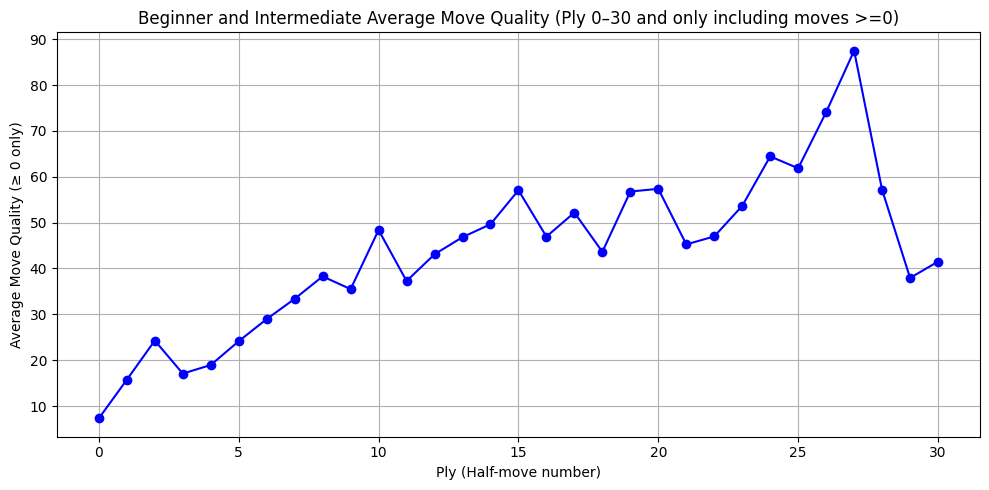

In [30]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Prepare: ply -> list of move qualities (only for beginners, move_quality >= 0)
beginner_quality_by_ply = defaultdict(list)

for game in data:
    white_elo_level = game.get("elo_level_white")
    black_elo_level = game.get("elo_level_black")
    
    for move in game.get("moves", []):
        ply = move.get("ply")
        mq = move.get("move_quality")
        player = move.get("player")

        if ply is None or ply > 30 or mq is None or mq < 0:
            continue

    
        if player == "white" and white_elo_level == "beginner" or white_elo_level == "intermediate":
            beginner_quality_by_ply[ply].append(mq)
        elif player == "black" and black_elo_level == "beginner" or black_elo_level == "intermediate":
            beginner_quality_by_ply[ply].append(mq)

# Compute average move quality per ply
avg_quality_by_ply = {
    ply: sum(vals) / len(vals)
    for ply, vals in beginner_quality_by_ply.items()
    if len(vals) > 0
}

# Sort plies and values for plotting
x = sorted(avg_quality_by_ply.keys())
y = [avg_quality_by_ply[ply] for ply in x]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', color='blue')
plt.title("Beginner and Intermediate Average Move Quality (Ply 0–30 and only including moves >=0)")
plt.xlabel("Ply (Half-move number)")
plt.ylabel("Average Move Quality (≥ 0 only)")
plt.grid(True)
plt.tight_layout()
plt.show()


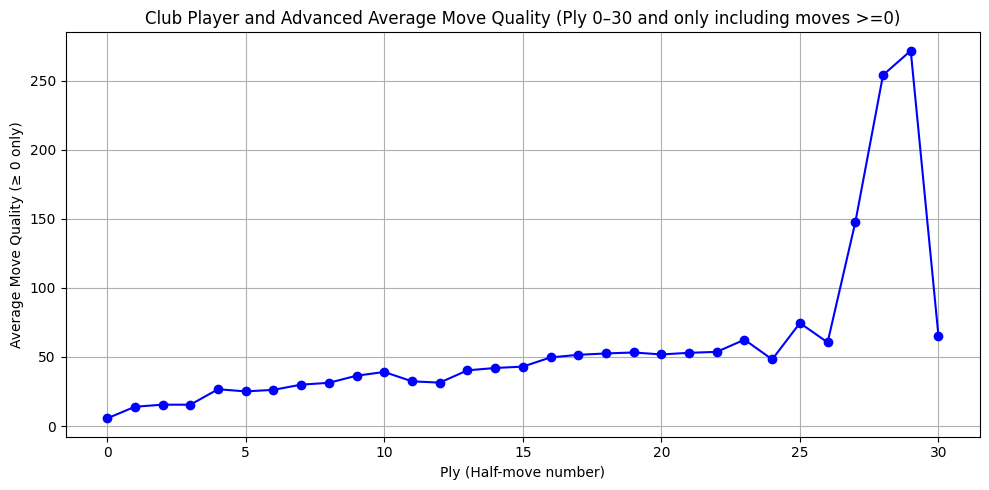

In [29]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Prepare: ply -> list of move qualities (only for beginners, move_quality >= 0)
beginner_quality_by_ply = defaultdict(list)

for game in data:
    white_elo_level = game.get("elo_level_white")
    black_elo_level = game.get("elo_level_black")
    
    for move in game.get("moves", []):
        ply = move.get("ply")
        mq = move.get("move_quality")
        player = move.get("player")

        if ply is None or ply > 30 or mq is None or mq < 0:
            continue

    
        if player == "white" and white_elo_level == "club_player" or white_elo_level == "advanced":
            beginner_quality_by_ply[ply].append(mq)
        elif player == "black" and black_elo_level == "club_player" or black_elo_level == "advanced":
            beginner_quality_by_ply[ply].append(mq)

# Compute average move quality per ply
avg_quality_by_ply = {
    ply: sum(vals) / len(vals)
    for ply, vals in beginner_quality_by_ply.items()
    if len(vals) > 0
}

# Sort plies and values for plotting
x = sorted(avg_quality_by_ply.keys())
y = [avg_quality_by_ply[ply] for ply in x]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', color='blue')
plt.title("Club Player and Advanced Average Move Quality (Ply 0–30 and only including moves >=0)")
plt.xlabel("Ply (Half-move number)")
plt.ylabel("Average Move Quality (≥ 0 only)")
plt.grid(True)
plt.tight_layout()
plt.show()


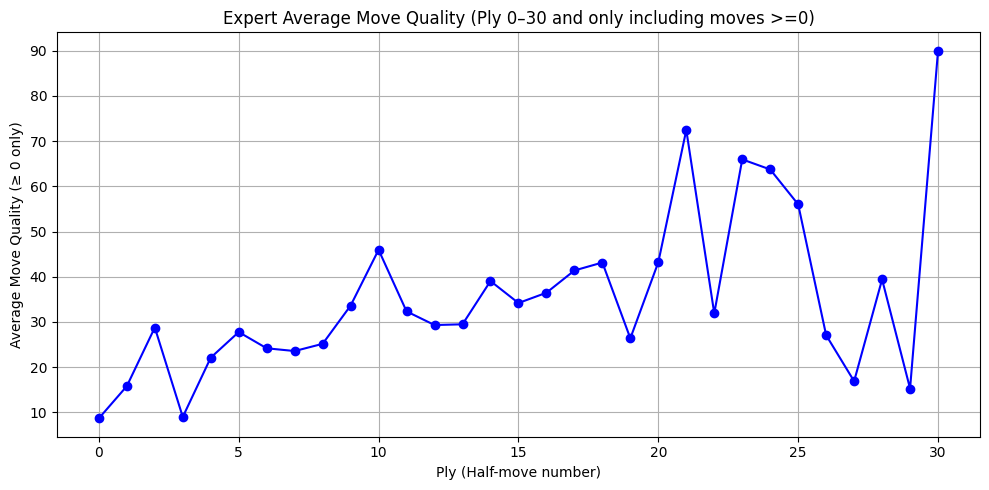

In [31]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Prepare: ply -> list of move qualities (only for beginners, move_quality >= 0)
beginner_quality_by_ply = defaultdict(list)

for game in data:
    white_elo_level = game.get("elo_level_white")
    black_elo_level = game.get("elo_level_black")
    
    for move in game.get("moves", []):
        ply = move.get("ply")
        mq = move.get("move_quality")
        player = move.get("player")

        if ply is None or ply > 30 or mq is None or mq < 0:
            continue

    
        if player == "white" and white_elo_level == "expert":
            beginner_quality_by_ply[ply].append(mq)
        elif player == "black" and black_elo_level == "expert":
            beginner_quality_by_ply[ply].append(mq)

# Compute average move quality per ply
avg_quality_by_ply = {
    ply: sum(vals) / len(vals)
    for ply, vals in beginner_quality_by_ply.items()
    if len(vals) > 0
}

# Sort plies and values for plotting
x = sorted(avg_quality_by_ply.keys())
y = [avg_quality_by_ply[ply] for ply in x]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', color='blue')
plt.title("Expert Average Move Quality (Ply 0–30 and only including moves >=0)")
plt.xlabel("Ply (Half-move number)")
plt.ylabel("Average Move Quality (≥ 0 only)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

# Initialize counters: player_vs_opponent[player_level][opponent_level] = {"wins": 0, "total": 0}
player_vs_opponent = {
    pl: {op: {"wins": 0, "total": 0} for op in elo_levels}
    for pl in elo_levels
}

for game in data:
    result = game.get("result")
    white_level = game.get("elo_level_white")
    black_level = game.get("elo_level_black")

    # White player perspective
    if white_level in elo_levels and black_level in elo_levels:
        player_vs_opponent[white_level][black_level]["total"] += 1
        if result == "1-0":
            player_vs_opponent[white_level][black_level]["wins"] += 1

    # Black player perspective
    if black_level in elo_levels and white_level in elo_levels:
        player_vs_opponent[black_level][white_level]["total"] += 1
        if result == "0-1":
            player_vs_opponent[black_level][white_level]["wins"] += 1

# Print matrix
print("Win Rate Matrix (Player vs Opponent):\n")
header = "Player \\ Opponent".ljust(18) + "".join(f"{op.ljust(14)}" for op in elo_levels)
print(header)
print("-" * len(header))
for pl in elo_levels:
    row = pl.ljust(18)
    for op in elo_levels:
        matchup = player_vs_opponent[pl][op]
        total = matchup["total"]
        wins = matchup["wins"]
        win_rate = (wins / total * 100) if total > 0 else 0
        row += f"{win_rate:6.1f}%".ljust(14)
    print(row)


Win Rate Matrix (Player vs Opponent):

Player \ Opponent beginner      intermediate  club_player   advanced      expert        
----------------------------------------------------------------------------------------
beginner            47.0%         58.8%         33.3%          0.0%          0.0%       
intermediate        41.2%         49.0%         42.3%          0.0%          0.0%       
club_player         66.7%         53.8%         49.2%         36.6%          0.0%       
advanced           100.0%        100.0%         58.5%         47.5%         47.6%       
expert               0.0%        100.0%          0.0%         42.9%         44.2%       


In [37]:
import numpy as np
from collections import defaultdict

# Define move quality bins (low to high)
bins = [50, 70, 90, 110, 130, 150, 1000]

# Stats for bin ranges
bin_stats_white = defaultdict(lambda: {"wins": 0, "total": 0})
bin_stats_black = defaultdict(lambda: {"wins": 0, "total": 0})

for game in data:
    moves = game.get("moves", [])
    result = game.get("result", "*")

    # Get move qualities
    white_qualities = [m["move_quality"] for m in moves if m.get("player") == "white" and m.get("move_quality") is not None]
    black_qualities = [m["move_quality"] for m in moves if m.get("player") == "black" and m.get("move_quality") is not None]

    if not white_qualities or not black_qualities:
        continue

    avg_white = np.mean(white_qualities)
    avg_black = np.mean(black_qualities)

    # Check for at least 20 point difference in favor
    if avg_black >= avg_white + 20:
        # White had better move quality
        w_bin = np.digitize(avg_white, bins) - 1
        w_range = f"{bins[w_bin]} < mq <= {bins[w_bin + 1]}"
        bin_stats_white[w_range]["total"] += 1
        if result == "1-0":
            bin_stats_white[w_range]["wins"] += 1

    elif avg_white >= avg_black + 20:
        # Black had better move quality
        b_bin = np.digitize(avg_black, bins) - 1
        b_range = f"{bins[b_bin]} < mq <= {bins[b_bin + 1]}"
        bin_stats_black[b_range]["total"] += 1
        if result == "0-1":
            bin_stats_black[b_range]["wins"] += 1

# Print white results
print("White player win percentage by avg move_quality (opponent at least 30 worse):")
for rng, stats in sorted(bin_stats_white.items()):
    pct = stats["wins"] / stats["total"] if stats["total"] > 0 else 0
    print(f"  {rng}: {pct:.2%} ({stats['wins']} wins / {stats['total']} games)")

# Print black results
print("\nBlack player win percentage by avg move_quality (opponent at least 30 worse):")
for rng, stats in sorted(bin_stats_black.items()):
    pct = stats["wins"] / stats["total"] if stats["total"] > 0 else 0
    print(f"  {rng}: {pct:.2%} ({stats['wins']} wins / {stats['total']} games)")


White player win percentage by avg move_quality (opponent at least 30 worse):
  1000 < mq <= 50: 48.96% (47 wins / 96 games)
  110 < mq <= 130: 0.00% (0 wins / 1 games)
  150 < mq <= 1000: 100.00% (1 wins / 1 games)
  50 < mq <= 70: 46.15% (6 wins / 13 games)
  70 < mq <= 90: 44.44% (4 wins / 9 games)
  90 < mq <= 110: 66.67% (2 wins / 3 games)

Black player win percentage by avg move_quality (opponent at least 30 worse):
  1000 < mq <= 50: 46.15% (30 wins / 65 games)
  150 < mq <= 1000: 100.00% (2 wins / 2 games)
  50 < mq <= 70: 42.86% (3 wins / 7 games)
  70 < mq <= 90: 66.67% (2 wins / 3 games)
  90 < mq <= 110: 50.00% (1 wins / 2 games)


In [13]:
thresholds = [50, 70, 90, 110, 130, 150, 1000]
max_ply_ranges = [2, 4, 6, 8, 10]  # Corresponds to first 1 to 5 White moves

for threshold in thresholds:
    print(f"\n=== Threshold: White avg move_quality < {threshold} AND Black avg at least 10 worse ===")
    
    for max_ply in max_ply_ranges:
        qualified_game_ids = []
        wins = 0

        for game in data:
            white_moves = [
                move["move_quality"]
                for move in game["moves"]
                if move["ply"] < max_ply and move["player"] == "white" and move.get("move_quality") is not None
            ]
            black_moves = [
                move["move_quality"]
                for move in game["moves"]
                if move["ply"] < max_ply and move["player"] == "black" and move.get("move_quality") is not None
            ]

            if not white_moves or not black_moves:
                continue

            avg_white = sum(white_moves) / len(white_moves)
            avg_black = sum(black_moves) / len(black_moves)

            # Include only if White plays worse than threshold and Black plays even worse by 20+
            if avg_white < threshold and (avg_black >= avg_white + 10):
                qualified_game_ids.append(game["game_nr"])
                if game["result"] == "1-0":
                    wins += 1

        total_games = len(qualified_game_ids)
        win_percentage = (wins / total_games) * 100 if total_games > 0 else 0

        print(f"White's first {max_ply // 2} moves: {total_games} games, Win %: {win_percentage:.2f}%")



=== Threshold: White avg move_quality < 50 AND Black avg at least 10 worse ===
White's first 1 moves: 296 games, Win %: 44.26%
White's first 2 moves: 256 games, Win %: 43.36%
White's first 3 moves: 249 games, Win %: 48.19%
White's first 4 moves: 220 games, Win %: 42.27%
White's first 5 moves: 221 games, Win %: 42.08%

=== Threshold: White avg move_quality < 70 AND Black avg at least 10 worse ===
White's first 1 moves: 296 games, Win %: 44.26%
White's first 2 moves: 256 games, Win %: 43.36%
White's first 3 moves: 252 games, Win %: 48.81%
White's first 4 moves: 227 games, Win %: 43.61%
White's first 5 moves: 231 games, Win %: 43.72%

=== Threshold: White avg move_quality < 90 AND Black avg at least 10 worse ===
White's first 1 moves: 296 games, Win %: 44.26%
White's first 2 moves: 257 games, Win %: 43.58%
White's first 3 moves: 252 games, Win %: 48.81%
White's first 4 moves: 229 games, Win %: 43.67%
White's first 5 moves: 233 games, Win %: 43.78%

=== Threshold: White avg move_quality <

Opening Sequence (moves)

In [16]:
from collections import Counter

sequence_counts = Counter()

for game in data:
    seq = game.get("human_opening_sequence", "")
    moves = seq.strip().split()
    first_5_moves = moves[:5]  # first 5 half moves
    seq_key = " ".join(first_5_moves)
    sequence_counts[seq_key] += 1

# Print sequences and how many times they appeared
for seq, count in sequence_counts.most_common():
    if count > 4:
        print(f"Sequence: {seq}\nCount: {count}\n")


Sequence: e4 e5 Nf3 Nc6 Bc4
Count: 22

Sequence: e4 e5 Nf3 Nc6 d4
Count: 21

Sequence: e4 e5 Nf3 Nc6 Bb5
Count: 17

Sequence: e4 d5 exd5 Qxd5 Nc3
Count: 15

Sequence: 
Count: 14

Sequence: e4 c5 Nf3 Nc6 d4
Count: 11

Sequence: e4 e5 Nf3 Nc6 Nc3
Count: 11

Sequence: e4 e5 Nf3 Nf6 Bc4
Count: 8

Sequence: e4 e5 Nf3 d6 Bc4
Count: 8

Sequence: e4 e5 Nf3 Nf6 Nc3
Count: 8

Sequence: e4 c5 Nf3 d6 d4
Count: 7

Sequence: e4 c6 d4 d5 e5
Count: 7

Sequence: e4 e6 Nf3 d5 exd5
Count: 7

Sequence: e4 e5 Nf3 d6 d4
Count: 6

Sequence: e4 e6 d4 d5 exd5
Count: 6

Sequence: d4 d5 c4 e6 Nc3
Count: 6

Sequence: e4 c6 d4 d5 exd5
Count: 6

Sequence: e4 d5 exd5 Qxd5 Nf3
Count: 6

Sequence: e4 g6 Nf3 Bg7 d4
Count: 6

Sequence: d4 Nf6 c4 g6 Nc3
Count: 5

Sequence: e4 e5 Nc3 Nc6 Bc4
Count: 5

Sequence: e4 c6 d4 d5 Nc3
Count: 5

Sequence: e4 c5 Nf3 e6 d4
Count: 5

Sequence: e4 g6 d4 Bg7 Nf3
Count: 5

Sequence: d4 d5 Bf4 Nf6 e3
Count: 5

Sequence: e4 c5 Nf3 Nc6 Bc4
Count: 5

Sequence: e4 c5 Nf3 Nc6 Bb5
Count: 5



In [18]:
import chess.pgn

def get_elo_bucket(elo):
    if elo < 1000:
        return "beginner"
    elif elo < 1400:
        return "intermediate"
    elif elo < 1800:
        return "club_player"
    elif elo < 2200:
        return "advanced"
    else:
        return "expert"

# Path to PGN file
PGN_FILE = "/workspaces/ChessSeminar/cleaned_one_line.pgn"

results = []

with open(PGN_FILE, encoding="utf-8") as pgn:
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break

        white_elo = int(game.headers.get("WhiteElo", 0))
        black_elo = int(game.headers.get("BlackElo", 0))
        opening = game.headers.get("Opening", "Unknown")

        white_level = get_elo_bucket(white_elo)
        black_level = get_elo_bucket(black_elo)

        results.append({
            "white_level": white_level,
            "black_level": black_level,
            "opening": opening
        })



In [22]:
from collections import Counter

# Step 1: Filter beginner games
beginner = [r for r in results if r["white_level"] == "beginner" and r["black_level"] == "beginner"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in beginner)

# Step 3: Print only those with >5 occurrences
print("Openings with a frequency of more than 5 only beginners:")
for opening, count in opening_counts.items():
    if count > 5:
        print(opening)


Openings with a frequency of more than 5 only beginners:
Philidor Defense
Scandinavian Defense
Four Knights Game: Italian Variation
Queen's Pawn Game


In [21]:
# Step 1: Filter intermediate games
intermediate = [r for r in results if r["white_level"] == "intermediate" and r["black_level"] == "intermediate"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in intermediate)

# Step 3: Print only those with >17 occurrences
print("Openings with a frequency of more than 17 only intermediate:")
for opening, count in opening_counts.items():
    if count > 17:
        print(opening)

Openings with a frequency of more than 17 only intermediate:
Queen's Pawn Game: Accelerated London System
Queen's Pawn Game
French Defense: Knight Variation
Van't Kruijs Opening
Philidor Defense


In [19]:
# Step 1: Filter games with club_player&advanced players
intermediate = [r for r in results if r["white_level"] == "club_player" or r["white_level"] == "advanced" and r["black_level"] == "club_player" or r["black_level"] == "advanced"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in intermediate)

# Step 3: Print only those with >53 occurrences
print("Openings with a frequency of more than 53 only club_player&advanced:")
for opening, count in opening_counts.items():
    if count > 53:
        print(opening)

Openings with a frequency of more than 53 only club_player&advanced:
Queen's Pawn Game
Pirc Defense
Owen Defense
Caro-Kann Defense


In [20]:
# Step 1: Filter expert games
intermediate = [r for r in results if r["white_level"] == "expert" and r["black_level"] == "expert"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in intermediate)

# Step 3: Print only those with >5 occurrences
print("Openings with a frequency of more than 5 only expert:")
for opening, count in opening_counts.items():
    if count > 5:
        print(opening)

Openings with a frequency of more than 5 only expert:
Queen's Pawn Game: Modern Defense
Indian Defense
English Opening: Agincourt Defense
